# 文本情感分类

文本分类是自然语言处理的一个常见任务，它把一段不定长的文本序列变换为文本的类别。本节关注它的一个子问题：使用文本情感分类来分析文本作者的情绪。这个问题也叫情感分析，并有着广泛的应用。

同搜索近义词和类比词一样，文本分类也属于词嵌入的下游应用。在本节中，我们将应用预训练的词向量和含多个隐藏层的双向循环神经网络与卷积神经网络，来判断一段不定长的文本序列中包含的是正面还是负面的情绪。后续内容将从以下几个方面展开：

1. 文本情感分类数据集
2. 使用循环神经网络进行情感分类
3. 使用卷积神经网络进行情感分类

In [4]:
import collections
import os
import random
import time
from tqdm import tqdm
import torch
from torch import nn
import torchtext.vocab as Vocab
import torch.utils.data as Data
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 文本情感分类数据

我们使用[斯坦福的IMDb数据集（Stanford’s Large Movie Review Dataset）](http://ai.stanford.edu/~amaas/data/sentiment/)作为文本情感分类的数据集。

### 读取数据

数据集文件夹结构：

```
| aclImdb_v1
    | train
    |   | pos
    |   |   | 0_9.txt  
    |   |   | 1_7.txt
    |   |   | ...
    |   | neg
    |   |   | 0_3.txt
    |   |   | 1_1.txt
    |   | ...
    | test
    |   | pos
    |   | neg
    |   | ...
    | ...
```

In [5]:
def read_imdb(folder='train', data_root="/home/kesci/input/IMDB2578/aclImdb_v1/aclImdb"):
    data = []
    for label in ['pos', 'neg']:
        folder_name = os.path.join(data_root, folder, label)
        for file in tqdm(os.listdir(folder_name)):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '').lower()
                data.append([review, 1 if label == 'pos' else 0])
    random.shuffle(data)
    return data

DATA_ROOT = "/home/kesci/input/IMDB2578/aclImdb_v1/"
data_root = os.path.join(DATA_ROOT, "aclImdb")
train_data, test_data = read_imdb('train', data_root), read_imdb('test', data_root)

# 打印训练数据中的前五个sample
for sample in train_data[:5]:
    print(sample[1], '\t', sample[0][:50])

100%|██████████| 12500/12500 [00:00<00:00, 52966.52it/s]

1 	 i'm 60 years old, a guitarist, (lead/rhythm), and 
0 	 it's the worst movie i've ever seen. the action is
1 	 i have seen the movie holes and say that it has to
1 	 i just saw this last night, it was broadcast on th
0 	 ...well, pop this into the dvd, waste an hour and 


### 预处理数据

读取数据后，我们先根据文本的格式进行单词的切分，再利用 [`torchtext.vocab.Vocab`](https://torchtext.readthedocs.io/en/latest/vocab.html#vocab) 创建词典。

In [6]:
def get_tokenized_imdb(data):
    '''
    @params:
        data: 数据的列表，列表中的每个元素为 [文本字符串，0/1标签] 二元组
    @return: 切分词后的文本的列表，列表中的每个元素为切分后的词序列
    '''
    def tokenizer(text):
        return [tok.lower() for tok in text.split(' ')]
    
    return [tokenizer(review) for review, _ in data]

def get_vocab_imdb(data):
    '''
    @params:
        data: 同上
    @return: 数据集上的词典，Vocab 的实例（freqs, stoi, itos）
    '''
    tokenized_data = get_tokenized_imdb(data)
    counter = collections.Counter([tk for st in tokenized_data for tk in st])
    return Vocab.Vocab(counter, min_freq=5)

vocab = get_vocab_imdb(train_data)
print('# words in vocab:', len(vocab))

# words in vocab: 46152


词典和词语的索引创建好后，就可以将数据集的文本从字符串的形式转换为单词下标序列的形式，以待之后的使用。

In [7]:
def preprocess_imdb(data, vocab):
    '''
    @params:
        data: 同上，原始的读入数据
        vocab: 训练集上生成的词典
    @return:
        features: 单词下标序列，形状为 (n, max_l) 的整数张量
        labels: 情感标签，形状为 (n,) 的0/1整数张量
    '''
    max_l = 500  # 将每条评论通过截断或者补0，使得长度变成500

    def pad(x):
        return x[:max_l] if len(x) > max_l else x + [0] * (max_l - len(x))

    tokenized_data = get_tokenized_imdb(data)
    features = torch.tensor([pad([vocab.stoi[word] for word in words]) for words in tokenized_data])
    labels = torch.tensor([score for _, score in data])
    return features, labels

### 创建数据迭代器

利用 [`torch.utils.data.TensorDataset`](https://pytorch.org/docs/stable/data.html?highlight=tensor%20dataset#torch.utils.data.TensorDataset)，可以创建 PyTorch 格式的数据集，从而创建数据迭代器。

In [6]:
train_set = Data.TensorDataset(*preprocess_imdb(train_data, vocab))
test_set = Data.TensorDataset(*preprocess_imdb(test_data, vocab))

# 上面的代码等价于下面的注释代码
# train_features, train_labels = preprocess_imdb(train_data, vocab)
# test_features, test_labels = preprocess_imdb(test_data, vocab)
# train_set = Data.TensorDataset(train_features, train_labels)
# test_set = Data.TensorDataset(test_features, test_labels)

# len(train_set) = features.shape[0] or labels.shape[0]
# train_set[index] = (features[index], labels[index])

batch_size = 64
train_iter = Data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = Data.DataLoader(test_set, batch_size)

for X, y in train_iter:
    print('X', X.shape, 'y', y.shape)
    break
print('#batches:', len(train_iter))

X torch.Size([64, 500]) y torch.Size([64])
#batches: 391


## 使用循环神经网络

### 双向循环神经网络

在[“双向循环神经网络”](https://zh.d2l.ai/chapter_recurrent-neural-networks/bi-rnn.html)一节中，我们介绍了其模型与前向计算的公式，这里简单回顾一下：

![Image Name](https://cdn.kesci.com/upload/image/q5mnobct47.png?imageView2/0/w/960/h/960)


![Image Name](https://cdn.kesci.com/upload/image/q5mo6okdnp.png?imageView2/0/w/960/h/960)


给定输入序列 $\{\boldsymbol{X}_1,\boldsymbol{X}_2,\dots,\boldsymbol{X}_T\}$，其中 $\boldsymbol{X}_t\in\mathbb{R}^{n\times d}$ 为时间步（批量大小为 $n$，输入维度为 $d$）。在双向循环神经网络的架构中，设时间步 $t$ 上的正向隐藏状态为 $\overrightarrow{\boldsymbol{H}}_{t} \in \mathbb{R}^{n \times h}$ （正向隐藏状态维度为 $h$），反向隐藏状态为 $\overleftarrow{\boldsymbol{H}}_{t} \in \mathbb{R}^{n \times h}$ （反向隐藏状态维度为 $h$）。我们可以分别计算正向隐藏状态和反向隐藏状态：


$$

\begin{aligned}
&\overrightarrow{\boldsymbol{H}}_{t}=\phi\left(\boldsymbol{X}_{t} \boldsymbol{W}_{x h}^{(f)}+\overrightarrow{\boldsymbol{H}}_{t-1} \boldsymbol{W}_{h h}^{(f)}+\boldsymbol{b}_{h}^{(f)}\right)\\
&\overleftarrow{\boldsymbol{H}}_{t}=\phi\left(\boldsymbol{X}_{t} \boldsymbol{W}_{x h}^{(b)}+\overleftarrow{\boldsymbol{H}}_{t+1} \boldsymbol{W}_{h h}^{(b)}+\boldsymbol{b}_{h}^{(b)}\right)
\end{aligned}

$$


其中权重 $\boldsymbol{W}_{x h}^{(f)} \in \mathbb{R}^{d \times h}, \boldsymbol{W}_{h h}^{(f)} \in \mathbb{R}^{h \times h}, \boldsymbol{W}_{x h}^{(b)} \in \mathbb{R}^{d \times h}, \boldsymbol{W}_{h h}^{(b)} \in \mathbb{R}^{h \times h}$ 和偏差 $\boldsymbol{b}_{h}^{(f)} \in \mathbb{R}^{1 \times h}, \boldsymbol{b}_{h}^{(b)} \in \mathbb{R}^{1 \times h}$ 均为模型参数，$\phi$ 为隐藏层激活函数。

然后我们连结两个方向的隐藏状态 $\overrightarrow{\boldsymbol{H}}_{t}$ 和 $\overleftarrow{\boldsymbol{H}}_{t}$ 来得到隐藏状态 $\boldsymbol{H}_{t} \in \mathbb{R}^{n \times 2 h}$，并将其输入到输出层。输出层计算输出 $\boldsymbol{O}_{t} \in \mathbb{R}^{n \times q}$（输出维度为 $q$）：


$$

\boldsymbol{O}_{t}=\boldsymbol{H}_{t} \boldsymbol{W}_{h q}+\boldsymbol{b}_{q}

$$


其中权重 $\boldsymbol{W}_{h q} \in \mathbb{R}^{2 h \times q}$ 和偏差 $\boldsymbol{b}_{q} \in \mathbb{R}^{1 \times q}$ 为输出层的模型参数。不同方向上的隐藏单元维度也可以不同。

利用 [`torch.nn.RNN`](https://pytorch.org/docs/stable/nn.html?highlight=rnn#torch.nn.RNN) 或 [`torch.nn.LSTM`](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM) 模组，我们可以很方便地实现双向循环神经网络，下面是以 LSTM 为例的代码。

In [7]:
class BiRNN(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_layers):
        '''
        @params:
            vocab: 在数据集上创建的词典，用于获取词典大小
            embed_size: 嵌入维度大小
            num_hiddens: 隐藏状态维度大小
            num_layers: 隐藏层个数
        '''
        super(BiRNN, self).__init__()
        self.embedding = nn.Embedding(len(vocab), embed_size)
        
        # encoder-decoder framework
        # bidirectional设为True即得到双向循环神经网络
        self.encoder = nn.LSTM(input_size=embed_size, 
                                hidden_size=num_hiddens, 
                                num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4*num_hiddens, 2) # 初始时间步和最终时间步的隐藏状态作为全连接层输入
        
    def forward(self, inputs):
        '''
        @params:
            inputs: 词语下标序列，形状为 (batch_size, seq_len) 的整数张量
        @return:
            outs: 对文本情感的预测，形状为 (batch_size, 2) 的张量
        '''
        # 因为LSTM需要将序列长度(seq_len)作为第一维，所以需要将输入转置
        embeddings = self.embedding(inputs.permute(1, 0)) # (seq_len, batch_size, d)
        # rnn.LSTM 返回输出、隐藏状态和记忆单元，格式如 outputs, (h, c)
        outputs, _ = self.encoder(embeddings) # (seq_len, batch_size, 2*h)
        encoding = torch.cat((outputs[0], outputs[-1]), -1) # (batch_size, 4*h)
        outs = self.decoder(encoding) # (batch_size, 2)
        return outs

embed_size, num_hiddens, num_layers = 100, 100, 2
net = BiRNN(vocab, embed_size, num_hiddens, num_layers)

### 加载预训练的词向量

由于预训练词向量的词典及词语索引与我们使用的数据集并不相同，所以需要根据目前的词典及索引的顺序来加载预训练词向量。

In [12]:
cache_dir = "/home/kesci/input/GloVe6B5429"
glove_vocab = Vocab.GloVe(name='6B', dim=100, cache=cache_dir)

def load_pretrained_embedding(words, pretrained_vocab):
    '''
    @params:
        words: 需要加载词向量的词语列表，以 itos (index to string) 的词典形式给出
        pretrained_vocab: 预训练词向量
    @return:
        embed: 加载到的词向量
    '''
    embed = torch.zeros(len(words), pretrained_vocab.vectors[0].shape[0]) # 初始化为0
    oov_count = 0 # out of vocabulary
    for i, word in enumerate(words):
        try:
            idx = pretrained_vocab.stoi[word]
            embed[i, :] = pretrained_vocab.vectors[idx]
        except KeyError:
            oov_count += 1
    if oov_count > 0:
        print("There are %d oov words." % oov_count)
    return embed

net.embedding.weight.data.copy_(load_pretrained_embedding(vocab.itos, glove_vocab))
net.embedding.weight.requires_grad = False # 直接加载预训练好的, 所以不需要更新它

 99%|█████████▉| 397764/400000 [00:15<00:00, 27536.08it/s]

There are 21202 oov words.


 99%|█████████▉| 397764/400000 [00:30<00:00, 27536.08it/s]

### 训练模型

训练时可以调用之前编写的 `train` 及 `evaluate_accuracy` 函数。

In [13]:
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        device = list(net.parameters())[0].device 
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval()
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train()
            else:
                if('is_training' in net.__code__.co_varnames):
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n

def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y) 
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

由于嵌入层的参数是不需要在训练过程中被更新的，所以我们利用 `filter` 函数和 `lambda` 表达式来过滤掉模型中不需要更新参数的部分。

In [25]:
lr, num_epochs = 0.01, 5
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
loss = nn.CrossEntropyLoss()

train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

training on  cpu
epoch 1, loss 0.9336, train acc 0.658, test acc 0.788, time 361.3 sec
epoch 2, loss 0.2986, train acc 0.811, test acc 0.744, time 364.4 sec
epoch 3, loss 0.1692, train acc 0.879, test acc 0.791, time 353.2 sec
epoch 4, loss 0.1331, train acc 0.910, test acc 0.782, time 361.1 sec
epoch 5, loss 0.1177, train acc 0.918, test acc 0.771, time 366.7 sec


```
training on  cuda
100%|█████████▉| 398892/400000 [00:40<00:00, 18148.73it/s]
epoch 1, loss 0.6206, train acc 0.631, test acc 0.798, time 41.7 sec
epoch 2, loss 0.2079, train acc 0.813, test acc 0.819, time 42.1 sec
epoch 3, loss 0.1186, train acc 0.843, test acc 0.847, time 40.8 sec
epoch 4, loss 0.0777, train acc 0.869, test acc 0.854, time 41.2 sec
epoch 5, loss 0.0544, train acc 0.887, test acc 0.861, time 41.8 sec
```

*注：由于本地CPU上训练时间过长，故只截取了运行的结果，后同。大家可以自行在网站上训练。*

### 评价模型

In [15]:
def predict_sentiment(net, vocab, sentence):
    '''
    @params：
        net: 训练好的模型
        vocab: 在该数据集上创建的词典，用于将给定的单词序转换为单词下标的序列，从而输入模型
        sentence: 需要分析情感的文本，以单词序列的形式给出
    @return: 预测的结果，positive 为正面情绪文本，negative 为负面情绪文本
    '''
    device = list(net.parameters())[0].device # 读取模型所在的环境
    sentence = torch.tensor([vocab.stoi[word] for word in sentence], device=device)
    label = torch.argmax(net(sentence.view((1, -1))), dim=1)
    return 'positive' if label.item() == 1 else 'negative'

predict_sentiment(net, vocab, ['this', 'movie', 'is', 'so', 'great'])

'positive'

```
'positive'
```

In [16]:
predict_sentiment(net, vocab, ['this', 'movie', 'is', 'so', 'bad'])

'positive'

```
'negative'
```

## 使用卷积神经网络

### 一维卷积层

在介绍模型前我们先来解释一维卷积层的工作原理。与二维卷积层一样，一维卷积层使用一维的互相关运算。在一维互相关运算中，卷积窗口从输入数组的最左方开始，按从左往右的顺序，依次在输入数组上滑动。当卷积窗口滑动到某一位置时，窗口中的输入子数组与核数组按元素相乘并求和，得到输出数组中相应位置的元素。如图所示，输入是一个宽为 7 的一维数组，核数组的宽为 2。可以看到输出的宽度为 7−2+1=6，且第一个元素是由输入的最左边的宽为 2 的子数组与核数组按元素相乘后再相加得到的：0×1+1×2=2。

![Image Name](https://cdn.kesci.com/upload/image/q5mo8qs7dc.png?imageView2/0/w/960/h/960)


In [17]:
def corr1d(X, K):
    '''
    @params:
        X: 输入，形状为 (seq_len,) 的张量
        K: 卷积核，形状为 (w,) 的张量
    @return:
        Y: 输出，形状为 (seq_len - w + 1,) 的张量
    '''
    w = K.shape[0] # 卷积窗口宽度
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]): # 滑动窗口
        Y[i] = (X[i: i + w] * K).sum()
    return Y

X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
print(corr1d(X, K))

tensor([ 2.,  5.,  8., 11., 14., 17.])


多输入通道的一维互相关运算也与多输入通道的二维互相关运算类似：在每个通道上，将核与相应的输入做一维互相关运算，并将通道之间的结果相加得到输出结果。下图展示了含 3 个输入通道的一维互相关运算，其中阴影部分为第一个输出元素及其计算所使用的输入和核数组元素：0×1+1×2+1×3+2×4+2×(−1)+3×(−3)=2。

![Image Name](https://cdn.kesci.com/upload/image/q5moaawczv.png?imageView2/0/w/960/h/960)


In [18]:
def corr1d_multi_in(X, K):
    # 首先沿着X和K的通道维遍历并计算一维互相关结果。然后将所有结果堆叠起来沿第0维累加
    return torch.stack([corr1d(x, k) for x, k in zip(X, K)]).sum(dim=0)
    # [corr1d(X[i], K[i]) for i in range(X.shape[0])]

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
print(corr1d_multi_in(X, K))

tensor([ 2.,  8., 14., 20., 26., 32.])


由二维互相关运算的定义可知，多输入通道的一维互相关运算可以看作单输入通道的二维互相关运算。如图所示，我们也可以将图中多输入通道的一维互相关运算以等价的单输入通道的二维互相关运算呈现。这里核的高等于输入的高。图中的阴影部分为第一个输出元素及其计算所使用的输入和核数组元素：2×(−1)+3×(−3)+1×3+2×4+0×1+1×2=2。

![Image Name](https://cdn.kesci.com/upload/image/q5moav6ue3.png?imageView2/0/w/960/h/960)

*注：反之仅当二维卷积核的高度等于输入的高度时才成立。*

之前的例子中输出都只有一个通道。我们在[“多输入通道和多输出通道”](https://zh.d2l.ai/chapter_convolutional-neural-networks/channels.html)一节中介绍了如何在二维卷积层中指定多个输出通道。类似地，我们也可以在一维卷积层指定多个输出通道，从而拓展卷积层中的模型参数。

### 时序最大池化层

类似地，我们有一维池化层。TextCNN 中使用的时序最大池化（max-over-time pooling）层实际上对应一维全局最大池化层：假设输入包含多个通道，各通道由不同时间步上的数值组成，各通道的输出即该通道所有时间步中最大的数值。因此，时序最大池化层的输入在各个通道上的时间步数可以不同。

![Image Name](https://cdn.kesci.com/upload/image/q5mobv3kol.png?imageView2/0/w/960/h/960)

*注：自然语言中还有一些其他的池化操作，可参考这篇[博文](https://blog.csdn.net/malefactor/article/details/51078135)。*

为提升计算性能，我们常常将不同长度的时序样本组成一个小批量，并通过在较短序列后附加特殊字符（如0）令批量中各时序样本长度相同。这些人为添加的特殊字符当然是无意义的。由于时序最大池化的主要目的是抓取时序中最重要的特征，它通常能使模型不受人为添加字符的影响。
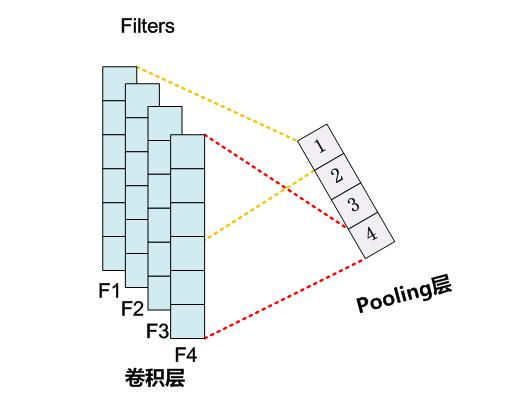

In [19]:
class GlobalMaxPool1d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool1d, self).__init__()
    def forward(self, x):
        '''
        @params:
            x: 输入，形状为 (batch_size, n_channels, seq_len) 的张量
        @return: 时序最大池化后的结果，形状为 (batch_size, n_channels, 1) 的张量
        '''
        return F.max_pool1d(x, kernel_size=x.shape[2]) # kenerl_size=seq_len

### TextCNN 模型

TextCNN 模型主要使用了一维卷积层和时序最大池化层。假设输入的文本序列由 $n$ 个词组成，每个词用 $d$ 维的词向量表示。那么输入样本的宽为 $n$，输入通道数为 $d$。TextCNN 的计算主要分为以下几步。

1. 定义多个一维卷积核，并使用这些卷积核对输入分别做卷积计算。宽度不同的卷积核可能会捕捉到不同个数的相邻词的相关性。
2. 对输出的所有通道分别做时序最大池化，再将这些通道的池化输出值连结为向量。
3. 通过全连接层将连结后的向量变换为有关各类别的输出。这一步可以使用丢弃层应对过拟合。

下图用一个例子解释了 TextCNN 的设计。这里的输入是一个有 11 个词的句子，每个词用 6 维词向量表示。因此输入序列的宽为 11，输入通道数为 6。给定 2 个一维卷积核，核宽分别为 2 和 4，输出通道数分别设为 4 和 5。因此，一维卷积计算后，4 个输出通道的宽为 11−2+1=10，而其他 5 个通道的宽为 11−4+1=8。尽管每个通道的宽不同，我们依然可以对各个通道做时序最大池化，并将 9 个通道的池化输出连结成一个 9 维向量。最终，使用全连接将 9 维向量变换为 2 维输出，即正面情感和负面情感的预测。

![Image Name](https://cdn.kesci.com/upload/image/q5modgownf.png?imageView2/0/w/960/h/960)

下面我们来实现 TextCNN 模型。与上一节相比，除了用一维卷积层替换循环神经网络外，这里我们还使用了两个嵌入层，一个的权重固定，另一个则参与训练。

In [24]:
class TextCNN(nn.Module):
    def __init__(self, vocab, embed_size, kernel_sizes, num_channels):
        '''
        @params:
            vocab: 在数据集上创建的词典，用于获取词典大小
            embed_size: 嵌入维度大小
            kernel_sizes: 卷积核大小列表
            num_channels: 卷积通道数列表
        '''
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(len(vocab), embed_size) # 参与训练的嵌入层
        self.constant_embedding = nn.Embedding(len(vocab), embed_size) # 不参与训练的嵌入层
        
        self.pool = GlobalMaxPool1d() # 时序最大池化层没有权重，所以可以共用一个实例
        self.convs = nn.ModuleList()  # 创建多个一维卷积层
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(in_channels = 2*embed_size, 
                                        out_channels = c, 
                                        kernel_size = k))
            
        self.decoder = nn.Linear(sum(num_channels), 2)
        self.dropout = nn.Dropout(0.5) # 丢弃层用于防止过拟合

    def forward(self, inputs):
        '''
        @params:
            inputs: 词语下标序列，形状为 (batch_size, seq_len) 的整数张量
        @return:
            outputs: 对文本情感的预测，形状为 (batch_size, 2) 的张量
        '''
        embeddings = torch.cat((
            self.embedding(inputs), 
            self.constant_embedding(inputs)), dim=2) # (batch_size, seq_len, 2*embed_size)
        # 根据一维卷积层要求的输入格式，需要将张量进行转置
        embeddings = embeddings.permute(0, 2, 1) # (batch_size, 2*embed_size, seq_len)
        
        encoding = torch.cat([
            self.pool(F.relu(conv(embeddings))).squeeze(-1) for conv in self.convs], dim=1)
        # encoding = []
        # for conv in self.convs:
        #     out = conv(embeddings) # (batch_size, out_channels, seq_len-kernel_size+1)
        #     out = self.pool(F.relu(out)) # (batch_size, out_channels, 1)
        #     encoding.append(out.squeeze(-1)) # (batch_size, out_channels)
        # encoding = torch.cat(encoding) # (batch_size, out_channels_sum)
        
        # 应用丢弃法后使用全连接层得到输出
        outputs = self.decoder(self.dropout(encoding))
        return outputs

embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
net = TextCNN(vocab, embed_size, kernel_sizes, nums_channels)

### 训练并评价模型

In [26]:
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
loss = nn.CrossEntropyLoss()
train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

training on  cpu
epoch 1, loss 0.2317, train acc 0.956, test acc 0.782, time 374.0 sec
epoch 2, loss 0.0527, train acc 0.973, test acc 0.780, time 372.5 sec
epoch 3, loss 0.0211, train acc 0.981, test acc 0.783, time 375.3 sec
epoch 4, loss 0.0119, train acc 0.985, test acc 0.788, time 370.7 sec
epoch 5, loss 0.0078, train acc 0.989, test acc 0.791, time 370.8 sec


```
training on  cuda
epoch 1, loss 0.6314, train acc 0.666, test acc 0.803, time 15.9 sec
epoch 2, loss 0.2416, train acc 0.766, test acc 0.807, time 15.9 sec
epoch 3, loss 0.1330, train acc 0.821, test acc 0.849, time 15.9 sec
epoch 4, loss 0.0825, train acc 0.858, test acc 0.860, time 16.0 sec
epoch 5, loss 0.0494, train acc 0.898, test acc 0.865, time 15.9 sec
```

In [8]:
predict_sentiment(net, vocab, ['this', 'movie', 'is', 'so', 'great'])

```
'positive'
```

In [11]:
predict_sentiment(net, vocab, ['this', 'movie', 'is', 'so', 'bad'])

```
'negative'
```